In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
ROOT = "."
SIM = 0 # choose
FIGURES_FOLDER = ROOT + f"/Figures/sim{SIM}/"
SIM_FOLDER = ROOT + f"/Simulations/sim{SIM}/"

if not os.path.exists(FIGURES_FOLDER):
    os.mkdir(FIGURES_FOLDER)
if not os.path.exists(SIM_FOLDER):
    os.mkdir(SIM_FOLDER)

C:\Users\nicol\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


NameError: name 'os' is not defined

In [2]:
def G(rho, p, P):
  return p*(1-rho/P)

# 2D parameter derivation:
# delta^2 / (4*tau) -> D for delta, tau -> 0
# Du = theta_u * D
# Di = theta_i * D

delta = 0.1 # mm
tau = 0.2 # h
D = delta**2/(4*tau)
Du = Di = 1.88e-4 # mm^2/h
theta_u = Du/D
theta_i = Di/D
beta = 1.02e-1 # h-1
p	= 1.87e-2 # h-1
q	= 4.17e-2 # h-1
P = K	= 1e4 # 1/mm^2
c_max = int(K*delta*delta)
Ru = 2.6 # mm
Ri = 1 # mm
pop_unit = 2

In [3]:
def initialize_mesh(delta, Ru, Ri, c_max):
  initial_u = int(.9*c_max)
  initial_i = int(.1*c_max)
  size = int(1/delta * 10 * 2)
  domain = np.zeros((2, size, size),dtype='u1')
  uint8 = np.iinfo(np.uint8)
  print("max of dtype:", uint8.max, ". cmax: ",c_max)
  for i in range(size):
    total_line = 0
    for j in range(size):
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ru)**2:
        domain[0][i][j] = initial_u
      if ((i-size/2)*delta)**2 + ((j-size/2)*delta)**2 <= (Ri)**2:
        domain[1][i][j] = initial_i
  return domain

domain = initialize_mesh(delta, Ru, Ri, c_max)

max of dtype: 255 . cmax:  100


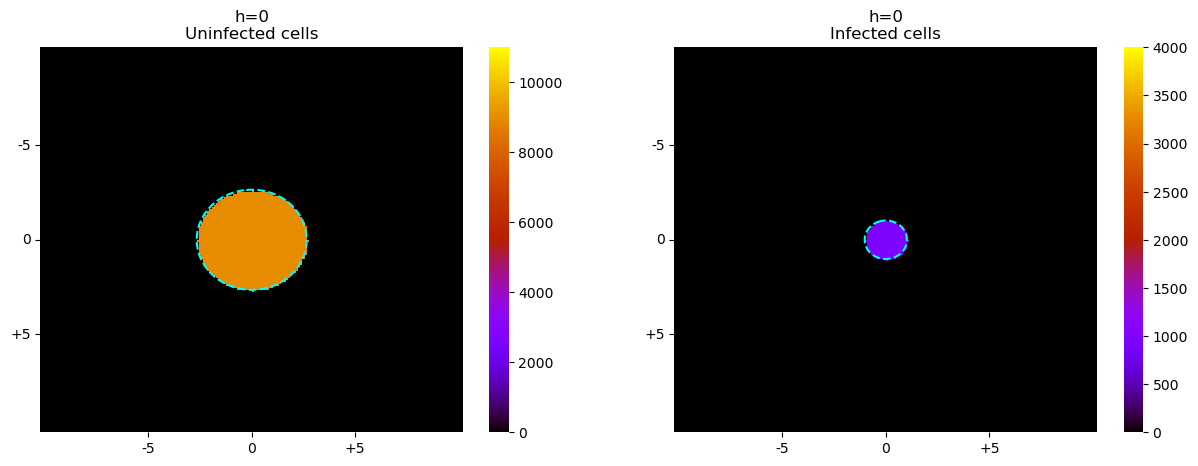

In [5]:
# define functions and parameters to save and plot results

def save_values(domain, h):
  np.save(f"{SIM_FOLDER}/sim{SIM}/sim{SIM}_h{h}.npy", domain)


def Circle(x, y, center):
  return (x-center)**2+(y-center)**2

size = int(1/delta * 10 * 2)
xx = np.linspace(0, size, size)
yy = np.linspace(0, size, size)
X, Y = np.meshgrid(xx,yy)
Z = Circle(X, Y, size//2)
ticks = [size//2 - 5//delta, size//2, size//2 + 5//delta]


def plot_domain(domain, h):
  radius_u = (Ru + h*2*np.sqrt(Du*p))/delta
  radius_i = (Ri + h*2*np.sqrt(Di*(beta-q)))/delta
  plt.figure(figsize=(15, 5))

  # plot U
  plt.subplot(1, 2, 1)
  ax1 = sns.heatmap(np.divide(domain[0],delta**2),vmin=0,vmax=K*1.1,cmap="gnuplot")
  ax1.set_xticks(ticks)
  ax1.set_xticklabels(["-5","0","+5"],rotation=0)
  ax1.set_yticks(ticks)
  ax1.set_yticklabels(["-5","0","+5"],rotation=0)
  ax1.title.set_text(f"h={h}\nUninfected cells")
  ax1.contour(X,Y,Z,[radius_u**2],colors=["cyan"],linestyles=["dashed"])

  # plot I
  plt.subplot(1, 2, 2)
  ax2 = sns.heatmap(np.divide(domain[1],delta**2),vmin=0,vmax=K*.4,cmap="gnuplot")
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(["-5","0","+5"],rotation=0)
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(["-5","0","+5"],rotation=0)
  ax2.title.set_text(f"h={h}\nInfected cells")
  ax2.contour(X,Y,Z,[radius_i**2],colors=["cyan"],linestyles=["dashed"])

  # save and plot figure
  # plt.savefig(f"{FIGURES_FOLDER}/random_walk_sim{SIM}_h{h}.png", format='png', dpi=200)
  plt.show()

plot_domain(domain, 0)

In [6]:
# def simulation functions

def random_move(space_next, cell_type, i, j, p_unit):
  prob_dist = [1-theta_u, theta_u/4, theta_u/4, theta_u/4, theta_u/4]
  action = np.random.choice(["stay", "up", "down", "right", "left"], p=prob_dist)
  if action == "up" and i > 0:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i-1][j] += p_unit
  elif action == "down" and i < space_next.shape[1]:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i+1][j] += p_unit
  elif action == "right" and j < space_next.shape[2]:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i][j+1] += p_unit
  elif action == "left" and j > 0:
    space_next[cell_type][i][j] -= p_unit
    space_next[cell_type][i][j-1] += p_unit

def select_u_action(space, space_next, i, j):
  cell_type = 0
  # reproduce or die or nothing:
  if space[0][i][j]+space[1][i][j] >= c_max:
    prob_to_die = max(-tau*p*(1-(space[0][i][j]+space[1][i][j])/c_max), 0)
    prob_dist = [1-prob_to_die, prob_to_die]
    action = np.random.choice(["live","die"], p=prob_dist)
    if action == "die":
      space[0][i][j] -= pop_unit
      space_next[0][i][j] -= pop_unit
      return
  else:
    prob_to_reproduce = max(tau*p*(1-(space[0][i][j]+space[1][i][j])/c_max), 0)
    prob_dist = [1-prob_to_reproduce, prob_to_reproduce]
    action = np.random.choice(["nothing","reproduce"], p=prob_dist)
    if action == "reproduce":
      space_next[0][i][j] += pop_unit

  # infect or not
  prob_to_infect = tau*beta*space[1][i][j]/c_max
  prob_dist = [1-prob_to_infect, prob_to_infect]
  action = np.random.choice(["no","infected"], p=prob_dist)
  if action == "infected":
    space_next[0][i][j] -= pop_unit
    space_next[1][i][j] += pop_unit
    cell_type = 1

  # move or stay
  random_move(space_next, cell_type, i, j, pop_unit)

def select_i_action(space, space_next, i, j):
  cell_type = 1
  # live or die:
  prob_to_die = tau*q
  prob_dist = [1-prob_to_die, prob_to_die]
  action = np.random.choice(["live","die"], p=prob_dist)
  if action == "die":
    space_next[1][i][j] -= 1
    return

  # move or stay
  random_move(space_next, cell_type, i, j, 1)

def random_walk_2D(space, space_next, tot_hours, h=0):
  time_steps = int((tot_hours-h)/tau)
  for time in range(time_steps):
    for i in range(space.shape[1]):
      for j in range(space.shape[2]):
        for u_cell in range(space[0][i][j]//pop_unit):
          # select what happens to uninfected tumor cell
          select_u_action(space, space_next, i, j)
        for i_cell in range(space[1][i][j]):
          # select what happens to infected tumor cell
          select_i_action(space, space_next, i, j)
    space = space_next.copy()
    if (time+1) % int(1/tau) == 0:
      h += 1
      print(f"hour = {h:4} / {tot_hours}")
      if h % 10 == 0:
        plot_domain(space, h)
        save_values(space, h)
  return space

In [7]:
# simulate

# code to use in case of recovered simulation:
# rec_h = 790
# domain = np.load(f"{SIM_FOLDER}/sim{SIM}_h{rec_h}.npy")

domain = random_walk_2D(domain, domain.copy(), tot_hours=1000) # h=rec_h

Output hidden; open in https://colab.research.google.com to view.